In [1]:
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

device = 'mps' if torch.backends.mps.is_available() else \
    'cuda' if torch.backends.cuda.is_available() else \
    'cpu'
#device = 'cpu'

In [2]:
datafolder = 'data'
fmnist = datasets.FashionMNIST(datafolder, download=True, train=True)
val_fmnist = datasets.FashionMNIST(datafolder, download=True, train=False)

tr_images = fmnist.data
tr_targets = fmnist.targets

val_images = val_fmnist.data
val_targets = val_fmnist.targets        

In [16]:
print(tr_images.shape)
fmnist.classes

torch.Size([60000, 28, 28])


['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [ ]:
class FMNISTDataset(Dataset):
    def __init__(self, x, y, aug=None):
        #x = x.float() / 255
        #x = x.view(-1, 1, 28, 28)
        self.x, self.y = x, y
        self.aug = aug
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x, y
        #return x.to(device), y.to(device)
    def __len__(self):
        return len(self.x)
    def collate_fn(self, batch):
        ims, classes = list(zip(*batch))
        ims = torch.stack(ims)
        if self.aug: 
            ims = self.aug.augment_images(images=ims.cpu().detach().numpy())
            ims = torch.tensor(ims)
        #self.tmp_ims = ims
        ims = ims[:,None,:,:].to(device)/255.
        classes = torch.tensor(classes).to(device)
        return ims, classes

In [3]:
from torch.optim import SGD, Adam

def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=3), # 1x28x28 --> 64x26x26
        nn.MaxPool2d(2), # --> 64x13x13
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3), #64x13x13 --> 128x11x11
        nn.MaxPool2d(2), # --> 128x5x5
        nn.ReLU(),
        nn.Flatten(), # 128x5x5 --> 128*5*5 = 3200
        nn.Linear(3200, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x, y, model):
    model.eval()
    prediction = model(x)
    max_vlues, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y
    return is_correct.cpu().numpy().tolist()

@torch.no_grad()
def validation_loss(x, y, model):
    model.eval()
    return loss_fn(model(x), y)

def get_data(aug=None):
    train = FMNISTDataset(tr_images, tr_targets, aug=aug)
    trn_dl = DataLoader(train, batch_size=64, collate_fn=train.collate_fn, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), collate_fn=val.collate_fn, shuffle=True)
    return trn_dl, val_dl

In [14]:
from torchsummary import summary
model, loss_fn, opt = get_model()
summary(model, torch.zeros(1,1,28,28));

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 64, 26, 26]          640
├─MaxPool2d: 1-2                         [-1, 64, 13, 13]          --
├─ReLU: 1-3                              [-1, 64, 13, 13]          --
├─Conv2d: 1-4                            [-1, 128, 11, 11]         73,856
├─MaxPool2d: 1-5                         [-1, 128, 5, 5]           --
├─ReLU: 1-6                              [-1, 128, 5, 5]           --
├─Flatten: 1-7                           [-1, 3200]                --
├─Linear: 1-8                            [-1, 256]                 819,456
├─ReLU: 1-9                              [-1, 256]                 --
├─Linear: 1-10                           [-1, 10]                  2,570
Total params: 896,522
Trainable params: 896,522
Non-trainable params: 0
Total mult-adds (M): 10.13
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 3.42
Estimated Total Size (MB): 3.8

In [5]:
import imgaug
print(imgaug.__version__)
print(device)

0.4.0
mps


In [10]:
from ai4res.utils import ProgressBar
import imgaug
from imgaug import augmenters as iaa
print(imgaug.__version__)

aug = iaa.Sequential([
    iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),
    ])

model, loss_fn, opt = get_model()
trn_dl, val_dl = get_data(aug)

trn_losses, trn_accuracies = [], []
val_losses, val_accuracies = [], []


epoch_step_len = ( len(trn_dl)*2+len(val_dl) ) / 25

for epoch in range(5):
    pb = ProgressBar(val=-1, end=epoch_step_len, prefix=f'EPOC: {epoch}')

    pb.print(suffix='training')    
    trn_elosses, trn_eaccuracies = [], []
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, opt, loss_fn)
        trn_elosses.append(batch_loss)
        if ix % 25 == 0: pb.step()
    trn_eloss = np.array(trn_elosses).mean()
    
    pb.print(suffix='accuracy on training set')
    for ix, batch in enumerate(iter(trn_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        trn_eaccuracies.extend(is_correct)
        if ix % 25 == 0: pb.step()
    trn_eaccuracy = np.mean(trn_eaccuracies)
    
    pb.print(suffix='accuracy on validation set')
    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        val_loss = validation_loss(x, y, model)
    val_eaccuracy = np.mean(val_is_correct)
    
    trn_losses.append(trn_eloss)
    trn_accuracies.append(trn_eaccuracy)
    val_losses.append(val_loss.item())
    val_accuracies.append(val_eaccuracy)

    pb.completed(suffix=f' accuracy: {val_eaccuracy*100}%')

    # EPOCH time on google.collab on CUDA A1: ~12s
    # EPOCH time on google.collab on CPU: ~300s (!)
    # EPOCH time on MacBoock Pro M1 Max CPU - standard: ~58s
    # EPOCH time on MacBoock Pro M1 Max CPU - con collate_fn senza filtri attivi: ~47s
    # EPOCH time on MacBoock Pro M1 Max CPU - con collate_fn con filtro di traslazione: ~68s
    # EPOCH time on MacBoock Pro M1 Max MPS - con collate_fn con filtro di traslazione: ~30

0.4.0
EPOC: 0 |██████████████████████████████████████████████████| 100.0%  accuracy: 81.15% [TIME: 30.92] 0.03s]
EPOC: 1 |██████████████████████████████████████████████████| 100.0%  accuracy: 85.61% [TIME: 30.67] 0.03s]
EPOC: 2 |██████████████████████████████████████████████████| 100.0%  accuracy: 86.67% [TIME: 30.59] 0.03s]
EPOC: 3 |██████████████████████████████████████████████████| 100.0%  accuracy: 87.78% [TIME: 31.39] 0.03s]
EPOC: 4 |██████████████████████████████████████████████████| 100.0%  accuracy: 87.76% [TIME: 31.06] 0.03s]


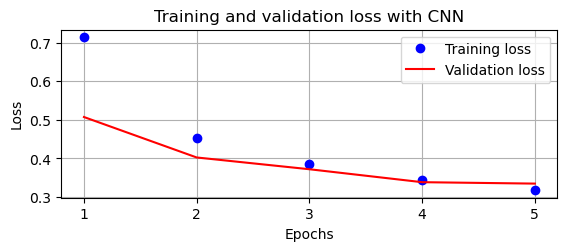

/var/folders/44/sqmxmlfx5k383gls301l5s100000gn/T/ipykernel_97995/4039430243.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


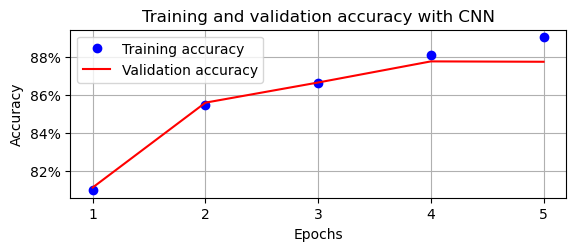

In [11]:
epochs = np.arange(5)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, trn_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, trn_accuracies, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with CNN')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
#plt.ylim(0.8,1)
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()]) 
plt.legend()
plt.grid('off')
plt.show()

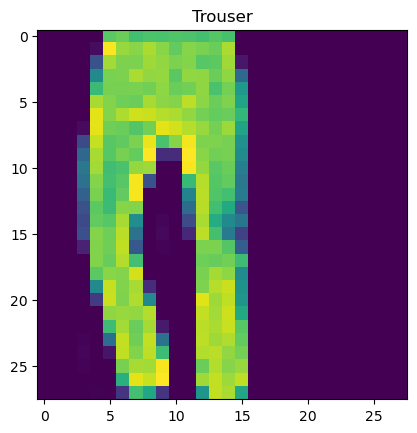

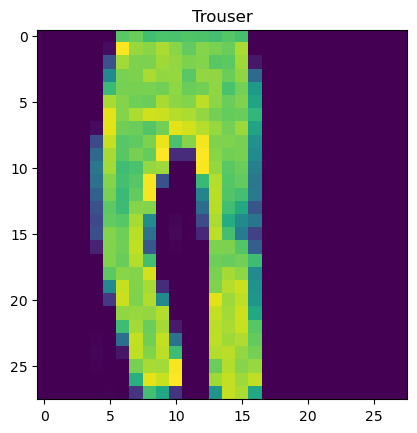

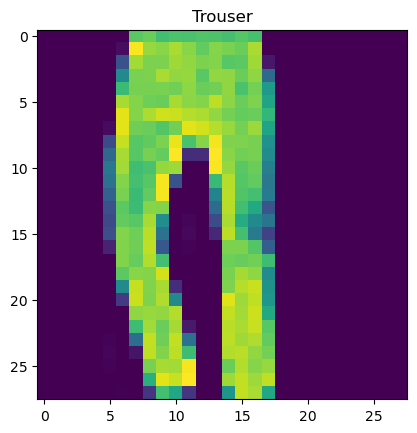

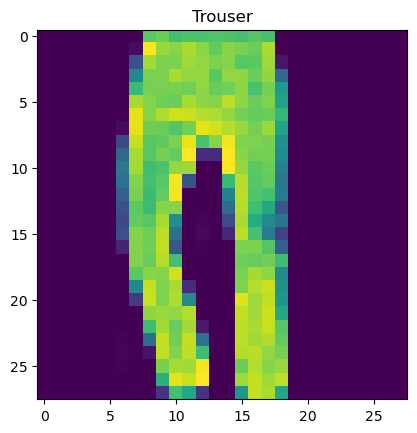

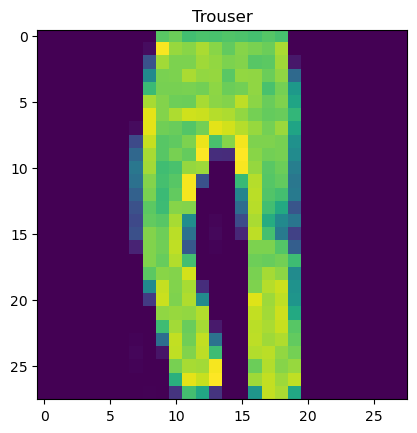

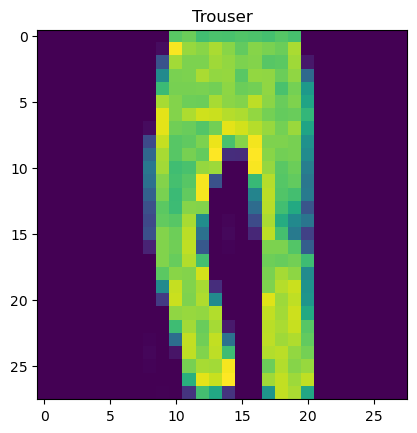

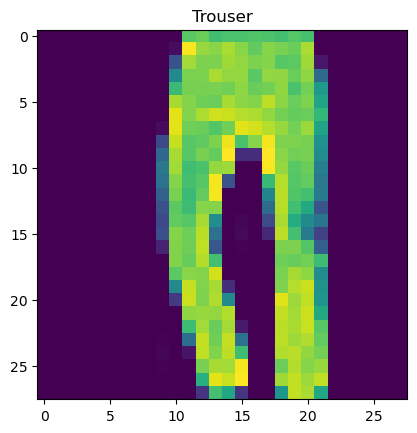

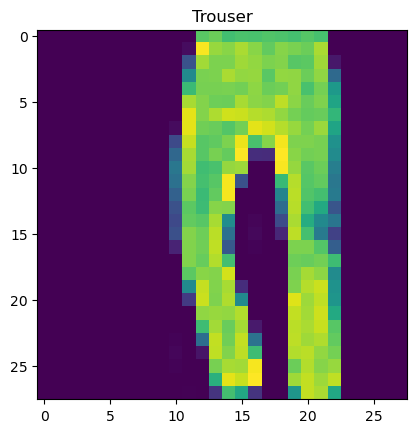

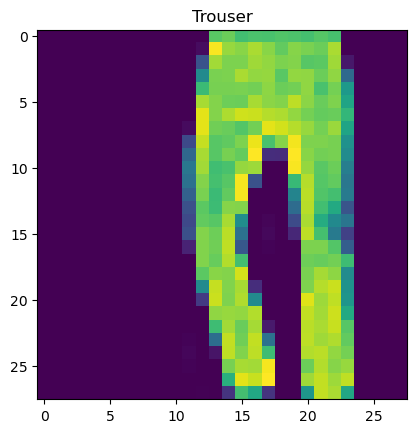

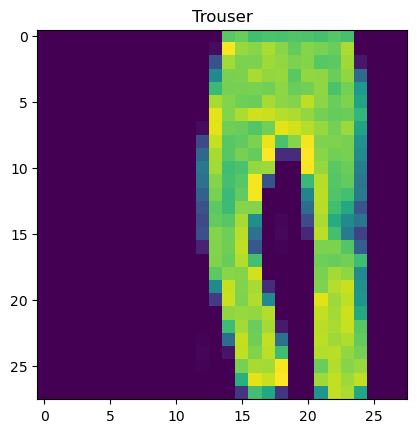

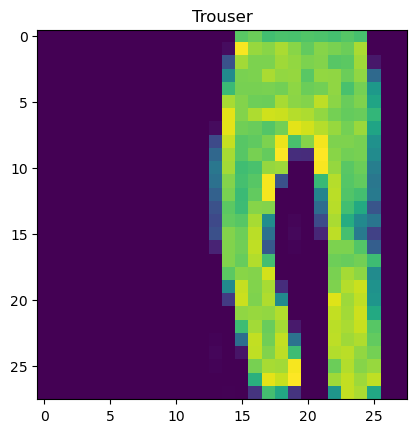

In [12]:
preds = []
ix = 24300
for px in range(-5,6):
    img = tr_images[ix]/255.
    img = img.view(28,28)
    img = np.roll(img, px, axis=1)
    img_data = torch.tensor(img).view(-1,1,28,28).to(device)
    np_out = model(img_data).cpu().detach().numpy()
    pred = np.exp(np_out) / np.sum(np.exp(np_out))
    preds.append(pred)
    plt.imshow(img)
    plt.title(fmnist.classes[pred[0].argmax()])
    plt.show()

<AxesSubplot:title={'center':'Probability of each class for various translations'}>

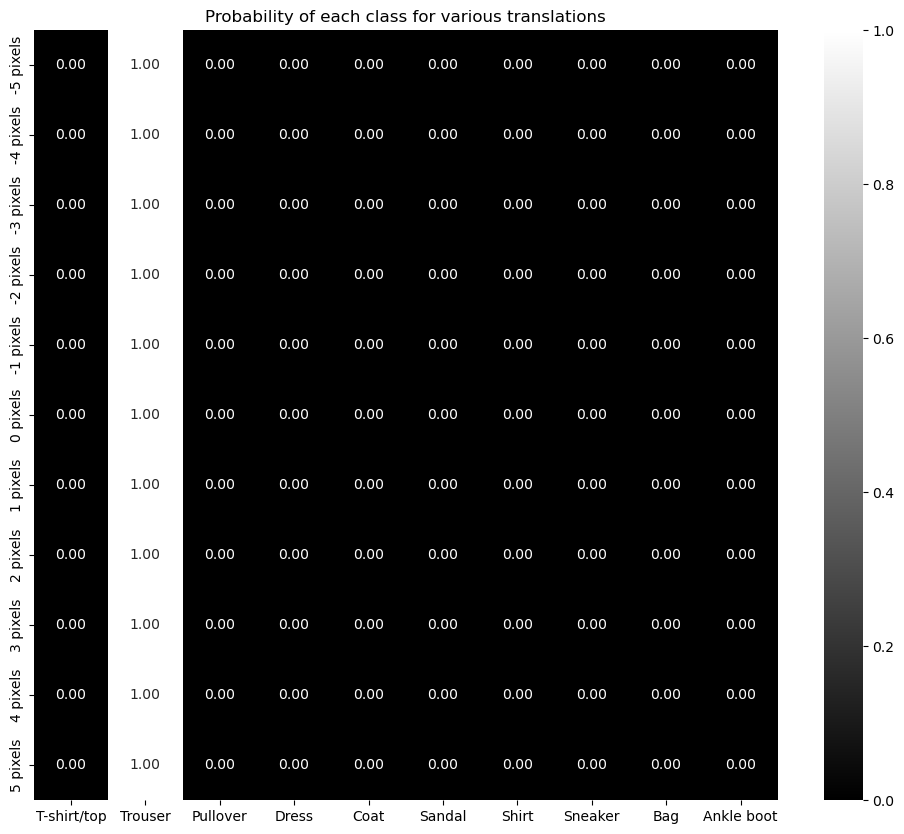

In [13]:
import seaborn as sns
fig, ax = plt.subplots(1,1, figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds).reshape(11,10), 
            annot=True, ax=ax, fmt='.2f', 
            xticklabels=fmnist.classes, 
            yticklabels=[str(i)+str(' pixels') for i in range(-5,6)], 
            cmap='gray')